## Imports

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import heartpy as hp
import scipy
from scipy import signal, stats, spatial, optimize, interpolate
from scipy.signal import butter, lfilter, resample, lfilter, medfilt, correlate
from statistics import mean, median
from datetime import datetime, timezone, timedelta
import pytz
import os
from classify import classify

## Convenience Functions

In [3]:
# Opens the CSV file from the MAXM86161 Software
def opencsv(name):
    with open(name) as fp:
        skip = next(filter(
            lambda x: x[1].startswith('timestamp'),
            enumerate(fp)
        ))[0]
    df = pd.read_csv(name, skiprows=skip)
    df.drop(df.tail(4).index,
            inplace = True)
    df['timestamp']=df['timestamp'].astype(float).astype(int)
    return df

# 5th Order Butterworth Lowpass Filter Implementation
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, fs, cutoff, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# 5th Order Butterworth Bandpass Filter Implementation 
def butter_bandpass(cutoff_l, cutoff_h, fs, order=5):
    nyq = 0.5 * fs
    b, a = signal.butter(order, [cutoff_l/nyq, cutoff_h/nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, fs, cutoff_l, cutoff_h, order=5):
    b, a = butter_bandpass(cutoff_l, cutoff_h, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Finds peaks in PPG and ECG signals
def peakfind_ecg(x, distance=40, prominence=0.3):
    peaks, _ = scipy.signal.find_peaks(x, distance=distance, prominence=prominence)
    return peaks

def peakfind_ppg(x, distance=40, prominence=200):
    peaks, _ = scipy.signal.find_peaks(x, distance=distance, prominence=prominence)
    return peaks

# Aligns PPG signals from the wrist and finger
def align_in_ref(p_in, p_ref, prom_ref=200, prom_in=200):
    peaks_in = peakfind_ppg(p_in, prominence=prom_in)
    peaks_ref = peakfind_ppg(p_ref, prominence=prom_ref)
    anchor = peaks_in[1]
    return min([pd - anchor for pd in peaks_ref], key=abs)

# Removes spikes from the pressure sensor reading
def remove_large_spikes(signal, threshold):
    smoothed_signal = medfilt(signal, kernel_size=3)
    spike_locations = np.abs(signal - smoothed_signal) > threshold
    cleaned_signal = np.where(spike_locations, smoothed_signal, signal)

    return cleaned_signal

# Converts timestamp strings to a unix timestamp
def convert_to_unix(timestamp_str, pattern, timezone_str='Asia/Singapore'):
    timestamp_format = pattern
    timestamp = datetime.strptime(timestamp_str, timestamp_format)
    input_timezone = pytz.timezone(timezone_str)
    timestamp = input_timezone.localize(timestamp)
    singapore_timezone = pytz.timezone("Asia/Singapore")
    timestamp_singapore = timestamp.astimezone(singapore_timezone)
    unix_timestamp = int(timestamp_singapore.timestamp())

    return unix_timestamp

# Aligns ECG and PPG signals
def find_peak_shift(decg, dppg):
    l=min(len(decg), len(dppg))
    decg = decg[:l]
    dppg = dppg[:l]
    
    r = dict()
    cr, _ = scipy.stats.pearsonr(decg, dppg)
    r.update({0: cr})
    
    for i in range(1, l//2):
        cr, _ = scipy.stats.pearsonr(decg[i:], dppg[:-i])
        r.update({i: cr})
    for i in range(1, l//2):
        cr, _ = scipy.stats.pearsonr(dppg[i:], decg[:-i])
        r.update({-i: cr})
    
    return int(max(r, key=r.get))

def reset_time(col, st, fact=1000):
    return (col - st) / fact

def get_prominence(p, fs):
    bpfed = butter_bandpass_filter(p, fs, 0.8, 3.5)
    bpfed -= min(bpfed)
    
    return median(bpfed)/3

def subtract_ac(time, sig, again=False):
    peaks = peakfind_ppg(sig, prominence=get_prominence(sig, 100)/100)
    line = interpolate.CubicSpline(time[peaks], sig[peaks])
    ac =  butter_lowpass_filter((sig - line(time))*-1, 100, 10)
    
    peaks = peakfind_ppg(-ac, prominence=get_prominence(ac, 100)/100)
    line = interpolate.CubicSpline(time[peaks], ac[peaks])
    ac = (ac - line(time))

    return ac


## Loading Files

In [4]:
s_id = '1000'

df_ppg_in = opencsv('raw_data/wrist_' + s_id +'.csv')
df_ppg_ref = opencsv('raw_data/finger_' + s_id +'.csv')
df_pressure = pd.read_csv('raw_data/pres_' + s_id +'.csv')
df_ecg = pd.read_csv('raw_data/ecg_' + s_id + '.csv')
df_spo2 = pd.read_csv('raw_data/spo2_' + s_id + '.csv')
df_bp = pd.read_csv('raw_data/bp_' + s_id + '.csv')

start = min(df_pressure['time'])

df_ppg_in['timestamp']=reset_time(df_ppg_in['timestamp'], start)
df_ppg_ref['timestamp']=reset_time(df_ppg_ref['timestamp'], start)

df_ppg_in['PPG_G_LPF_10Hz'] = butter_lowpass_filter(df_ppg_in['LEDC1'], 128, 10)
df_ppg_ref['PPG_G_LPF_10Hz'] = butter_lowpass_filter(df_ppg_ref['LEDC1'], 128, 10)

df_ppg_in['PPG_IR_LPF_10Hz'] = butter_lowpass_filter(df_ppg_in['LEDC2'], 128, 10)
df_ppg_ref['PPG_IR_LPF_10Hz'] = butter_lowpass_filter(df_ppg_ref['LEDC2'], 128, 10)

df_ppg_in['PPG_R_LPF_10Hz'] = butter_lowpass_filter(df_ppg_in['LEDC3'], 128, 10)
df_ppg_ref['PPG_R_LPF_10Hz'] = butter_lowpass_filter(df_ppg_ref['LEDC3'], 128, 10)

df_pressure['time']=reset_time(df_pressure['time'], start)

df_pressure['reading'] = remove_large_spikes(df_pressure['reading'], 400)
df_pressure['reading'] = butter_lowpass_filter(df_pressure['reading'], 80, 8)

df_ecg['time']/=1000000
df_ecg['time']-=start
df_ecg['time']/=1000

df_spo2['Timestamp'] = df_spo2['Time'].apply(lambda x: convert_to_unix(x, "%H:%M:%S %b %d %Y"))
df_bp['Timestamp'] = df_bp['Measurement Date'].apply(lambda x: convert_to_unix(x, "%Y/%m/%d %H:%M"))

df_spo2['Timestamp'] -= start//1000
df_bp['Timestamp'] -= start

/var/folders/db/jd5sxcv14dx66ylxdf8scbsc0000gn/T/ipykernel_42890/1510273101.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, skiprows=skip)
/var/folders/db/jd5sxcv14dx66ylxdf8scbsc0000gn/T/ipykernel_42890/1510273101.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, skiprows=skip)


## PPG-Pressure Synchronisation

Squeezing the sensors together with the fingers causes spikes in the PPG and Pressure signals that can be used for alignment. 

These spikes are seen between 5s and 15s

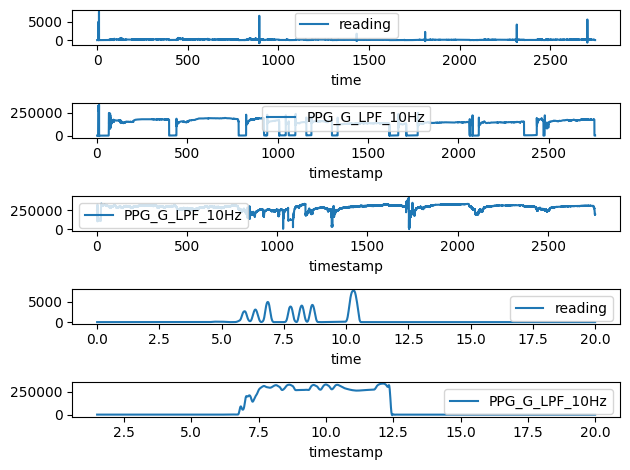

In [5]:
fig, axes = plt.subplots(5, 1)

df_pressure.plot(x='time', y='reading', ax=axes[0])
df_ppg_in.plot(x='timestamp', y='PPG_G_LPF_10Hz', ax=axes[1])
df_ppg_ref.plot(x='timestamp', y='PPG_G_LPF_10Hz', ax=axes[2])

limit_view_start = 0
limit_view_end = 20

df_pressure[df_pressure['time'].between(limit_view_start, limit_view_end)].plot(x='time', y='reading', ax=axes[3])
df_ppg_in[df_ppg_in['timestamp'].between(limit_view_start, limit_view_end)].plot(x='timestamp', y='PPG_G_LPF_10Hz', ax=axes[4])
plt.tight_layout()
plt.show()

Detect two corresponding peaks and adjust the timestamps accordingly. 

Note that stable readings begin from around t=100s

10.3 12.135
-1.834999999999999


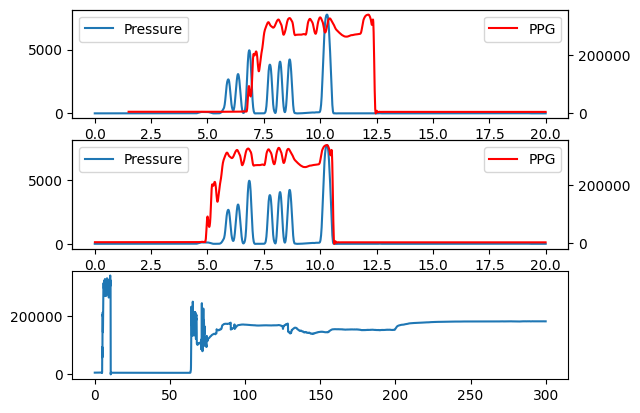

In [6]:
fig, axes = plt.subplots(3, 1)

df_pressure[df_pressure['time'].between(limit_view_start, limit_view_end)].plot(ax=axes[0], x='time', y='reading')
h,l = axes[0].get_legend_handles_labels()
axes[0].legend(h[:2], ['Pressure'], loc=2)
axes[0] = axes[0].twinx()
df_ppg_in[df_ppg_in['timestamp'].between(limit_view_start, limit_view_end)].plot(ax=axes[0], x='timestamp', y='PPG_G_LPF_10Hz', color="r")
axes[0].legend(['PPG'])

pres_s = 8
pres_e = 12
ppg_s = 10
ppg_e = 15

pres_max = df_pressure[df_pressure['time'].between(pres_s, pres_e)]['reading'].idxmax()
ppg_max = df_ppg_in[df_ppg_in['timestamp'].between(ppg_s, ppg_e)]['PPG_G_LPF_10Hz'].idxmax()

print(df_pressure.loc[pres_max]['time'], df_ppg_in.loc[ppg_max]['timestamp'])
correction = df_pressure.loc[pres_max]['time'] - df_ppg_in.loc[ppg_max]['timestamp']
print(correction)
df_ppg_in['timestamp'] += correction
df_ppg_ref['timestamp'] += correction

df_ecg['time'] += correction
df_spo2['Timestamp'] += correction
df_bp['Timestamp'] += correction

axes[1] = df_pressure[df_pressure['time'].between(limit_view_start, limit_view_end)].plot(ax=axes[1],x='time', y='reading')
h,l = axes[1].get_legend_handles_labels()
axes[1].legend(h[:2], ['Pressure'], loc=2)
axes[1] = axes[1].twinx()
df_ppg_in[df_ppg_in['timestamp'].between(limit_view_start, limit_view_end)].plot(ax=axes[1], x='timestamp', y='PPG_G_LPF_10Hz', color="r")
axes[1].legend(['PPG'])

df_ppg_look_4_start = df_ppg_in[df_ppg_in['timestamp'].between(limit_view_start, limit_view_start + 300)]
axes[2].plot(df_ppg_look_4_start['timestamp'], df_ppg_look_4_start['PPG_G_LPF_10Hz'])
plt.show()

## PPG-ECG Synchronisation

Select an arbitary segment of ECG and PPG signals without motion artifacts

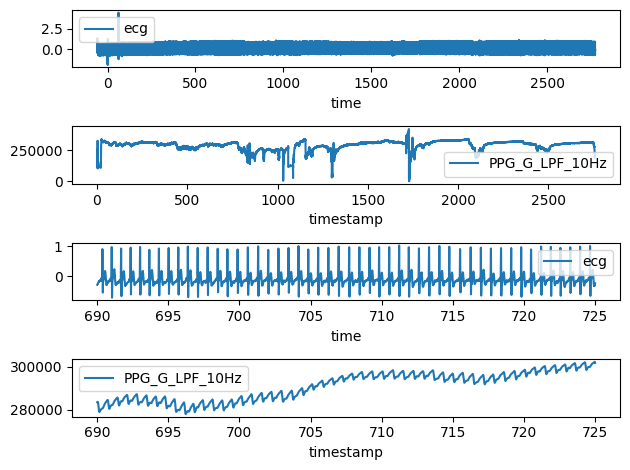

In [7]:
fig, axes = plt.subplots(4, 1)

df_ecg.plot(x='time', y='ecg', ax=axes[0])
df_ppg_ref.plot(x='timestamp', y='PPG_G_LPF_10Hz', ax=axes[1])

limit_view_start = 690
limit_view_end = 725

df_ecg[df_ecg['time'].between(limit_view_start, limit_view_end)].plot(x='time', y='ecg', ax=axes[2])
df_ppg_ref[df_ppg_ref['timestamp'].between(limit_view_start, limit_view_end)].plot(x='timestamp', y='PPG_G_LPF_10Hz', ax=axes[3])
plt.tight_layout()
plt.show()

Within the selected segment, calculate the distances between adjacent peaks to align the PPG and ECG signals

Shifting ECG signal backwards by -4 cycles


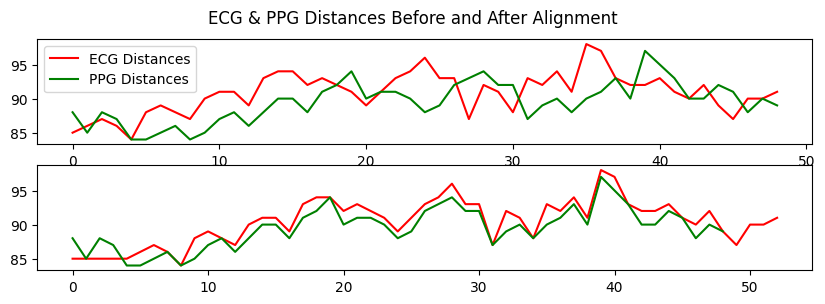

In [8]:
ecg_section = df_ecg[df_ecg['time'].between(limit_view_start, limit_view_end)]
ppg_section = df_ppg_ref[df_ppg_ref['timestamp'].between(limit_view_start, limit_view_end)]

peaks_ecg = peakfind_ecg(ecg_section['ecg'])
peaks_ppg = peakfind_ppg(ppg_section['PPG_G_LPF_10Hz'], prominence=500)

dists_ecg = []
for i in range(1, len(peaks_ecg)):
    dists_ecg.append(peaks_ecg[i] - peaks_ecg[i-1])

dists_ppg = []
for i in range(1, len(peaks_ppg)):
    dists_ppg.append(peaks_ppg[i] - peaks_ppg[i-1])

to_shift = find_peak_shift(dists_ecg, dists_ppg)
print('Shifting ECG signal backwards by', to_shift, 'cycles')

plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(dists_ecg, color='r')
plt.plot(dists_ppg, color='g')
plt.legend(["ECG Distances", "PPG Distances"])

plt.subplot(2, 1, 2)
if to_shift >= 0:
    plt.plot(dists_ecg, color='r')
    plt.plot(([dists_ppg[0]]*abs(to_shift)) + dists_ppg, color='g')
else:
    plt.plot(([dists_ecg[0]]*abs(to_shift)) + dists_ecg, color='r')
    plt.plot(dists_ppg, color='g')
    
plt.suptitle("ECG & PPG Distances Before and After Alignment")

plt.show()

Find the time between two peaks separated by the determined number of cycles and subtract it to align the signals

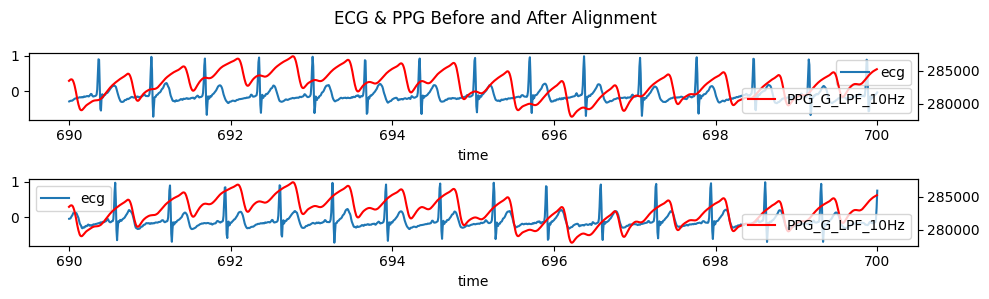

In [9]:
time_shift = ecg_section['time'].values[peaks_ecg[1 + abs(to_shift)]] - ppg_section['timestamp'].values[peaks_ppg[1]]

fig, axes = plt.subplots(2, 1)
fig.set_size_inches(10, 3)
fig.suptitle("ECG & PPG Before and After Alignment")

df_ecg[df_ecg['time'].between(limit_view_start, limit_view_start + 10)].plot(x='time', y='ecg', ax=axes[0])
axes[0] = axes[0].twinx()
df_ppg_ref[df_ppg_ref['timestamp'].between(limit_view_start, limit_view_start + 10)].plot(x='timestamp', y='PPG_G_LPF_10Hz', ax=axes[0], color='r')

if time_shift >= 0:
    df_ecg['time'] += time_shift
else:
    df_ecg['time'] -= time_shift

df_ecg[df_ecg['time'].between(limit_view_start, limit_view_start + 10)].plot(x='time', y='ecg', ax=axes[1])
axes[1] = axes[1].twinx()
df_ppg_ref[df_ppg_ref['timestamp'].between(limit_view_start, limit_view_start + 10)].plot(x='timestamp', y='PPG_G_LPF_10Hz', ax=axes[1], color='r')

plt.tight_layout()
plt.show()

## Trimming and Resampling

Trim each signal to the time period between the start of stable readings and the earliest end of recording on any device

In [10]:
# Find the start of content
start = 100

end = min(max(df_ppg_in['timestamp']), max(df_ppg_ref['timestamp']), max(df_pressure['time']), max(df_ecg['time']), max(df_spo2['Timestamp']))

df_ppg_in = df_ppg_in[df_ppg_in['timestamp'].between(start, end)].copy()
df_ppg_ref = df_ppg_ref[df_ppg_ref['timestamp'].between(start, end)].copy()
df_pressure = df_pressure[df_pressure['time'].between(start, end)].copy()
df_ecg = df_ecg[df_ecg['time'].between(start, end)].copy()
df_spo2 = df_spo2[df_spo2['Timestamp'].between(start, end)].copy()

Resample each trace to 100Hz

<Axes: xlabel='Time'>

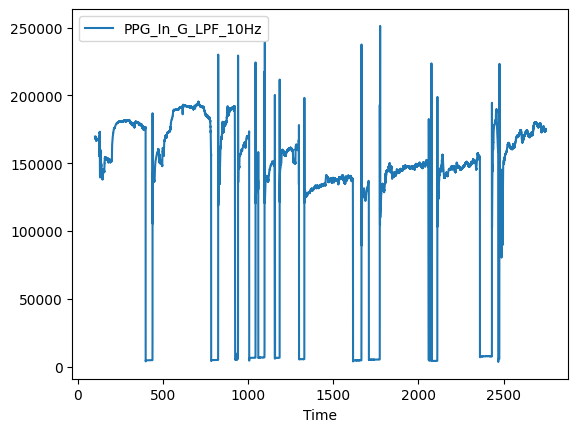

In [11]:
ln = int(len(df_ppg_in)*100/128)

trim=100

time = signal.resample(df_ppg_in['timestamp'], ln)[trim:-trim]

ppg_in_g = signal.resample(df_ppg_in['PPG_G_LPF_10Hz'], ln)[trim:-trim]
ppg_ref_g = signal.resample(df_ppg_ref['PPG_G_LPF_10Hz'], ln)[trim:-trim]

ppg_in_ir = signal.resample(df_ppg_in['PPG_IR_LPF_10Hz'], ln)[trim:-trim]
ppg_ref_ir = signal.resample(df_ppg_ref['PPG_IR_LPF_10Hz'], ln)[trim:-trim]

ppg_in_r = signal.resample(df_ppg_in['PPG_R_LPF_10Hz'], ln)[trim:-trim]
ppg_ref_r = signal.resample(df_ppg_ref['PPG_R_LPF_10Hz'], ln)[trim:-trim]

pressure = signal.resample(df_pressure['reading'], ln)[trim:-trim]
ecg = signal.resample(df_ecg['ecg'], ln)[trim:-trim]
spo2 = signal.resample(df_spo2['Oxygen Level'], ln)[trim:-trim]

df_final = pd.DataFrame(data={\
                              'Time': time,\
                              'PPG_In_G_LPF_10Hz': ppg_in_g,\
                              'PPG_In_IR_LPF_10Hz': ppg_in_ir,\
                              'PPG_In_R_LPF_10Hz': ppg_in_r,\
                              'PPG_Ref_G_LPF_10Hz': ppg_ref_g,\
                              'PPG_Ref_IR_LPF_10Hz': ppg_ref_ir,\
                              'PPG_Ref_R_LPF_10Hz': ppg_ref_r,\
                              'Pressure_In': pressure,\
                              'ECG': ecg,\
                              'SpO2': spo2
                             })

df_final.plot(x='Time', y='PPG_In_G_LPF_10Hz')

Extract relevant 4-minute windows and save the (mostly) raw signals

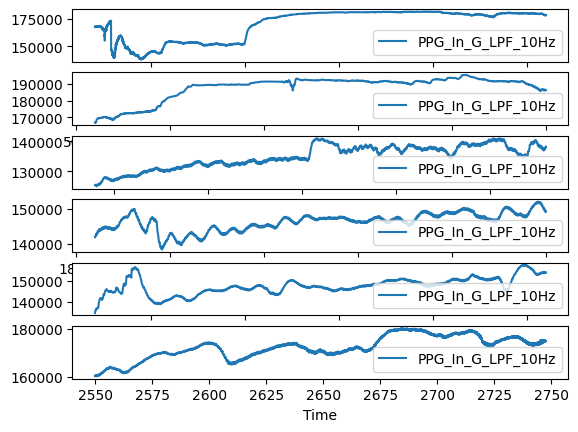

In [12]:
windows = []

idxs = [[120, 360], [510, 750], [1340, 1580], [1810, 2050], [2120, 2360], [2550, 2790]]

fig, axes = plt.subplots(len(idxs), 1)

for i, idx in enumerate(idxs):
    a = idx[0]
    b = idx[1]
    small = df_final[df_final['Time'].between(a, b)].copy()
    
    small['BP_Sys'] = df_bp['SYS(mmHg)'].values[i]
    small['BP_Dia'] = df_bp['DIA(mmHg)'].values[i]
    
    small.plot(ax=axes[i], x='Time', y='PPG_In_G_LPF_10Hz')

    small['Time'] = np.sort(small['Time'].values)
    
    windows.append(small[['Time', 'PPG_In_G_LPF_10Hz', 'PPG_In_IR_LPF_10Hz', 'PPG_In_R_LPF_10Hz',
           'PPG_Ref_G_LPF_10Hz', 'PPG_Ref_IR_LPF_10Hz', 'PPG_Ref_R_LPF_10Hz', 
           'Pressure_In', 'ECG', 'BP_Sys', 'BP_Dia', 'SpO2']].copy())

## Extract AC Component

Remove the AC component from each window by identifying waveform feet, fitting a cubic spline through them and subtracting the resulting spline

In [13]:
i=0

for window in windows:
    # Removing the AC Component
    window['PPG_In_G_AC'] = subtract_ac(window['Time'].values, window['PPG_In_G_LPF_10Hz'].values)

    window['PPG_Ref_G_AC'] = subtract_ac(window['Time'].values, window['PPG_Ref_G_LPF_10Hz'].values)
    window['PPG_Ref_IR_AC'] = subtract_ac(window['Time'].values, window['PPG_Ref_IR_LPF_10Hz'].values)
    window['PPG_Ref_R_AC'] = subtract_ac(window['Time'].values, window['PPG_Ref_R_LPF_10Hz'].values)
    
    window.to_csv('processed/' + str(i) + '_preprocessed_' + s_id + '.csv')
    i+=1

## Visualising the Result


Sys BP 145 Dia BP 92


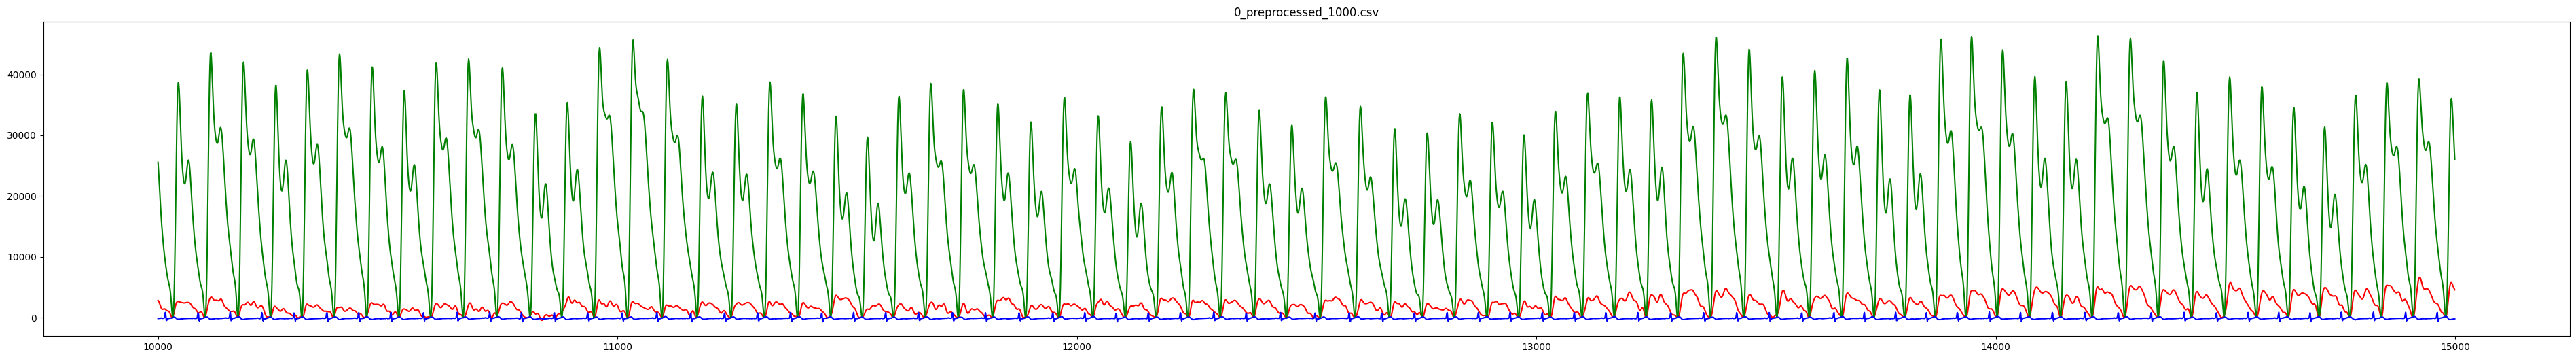

Sys BP 131 Dia BP 87


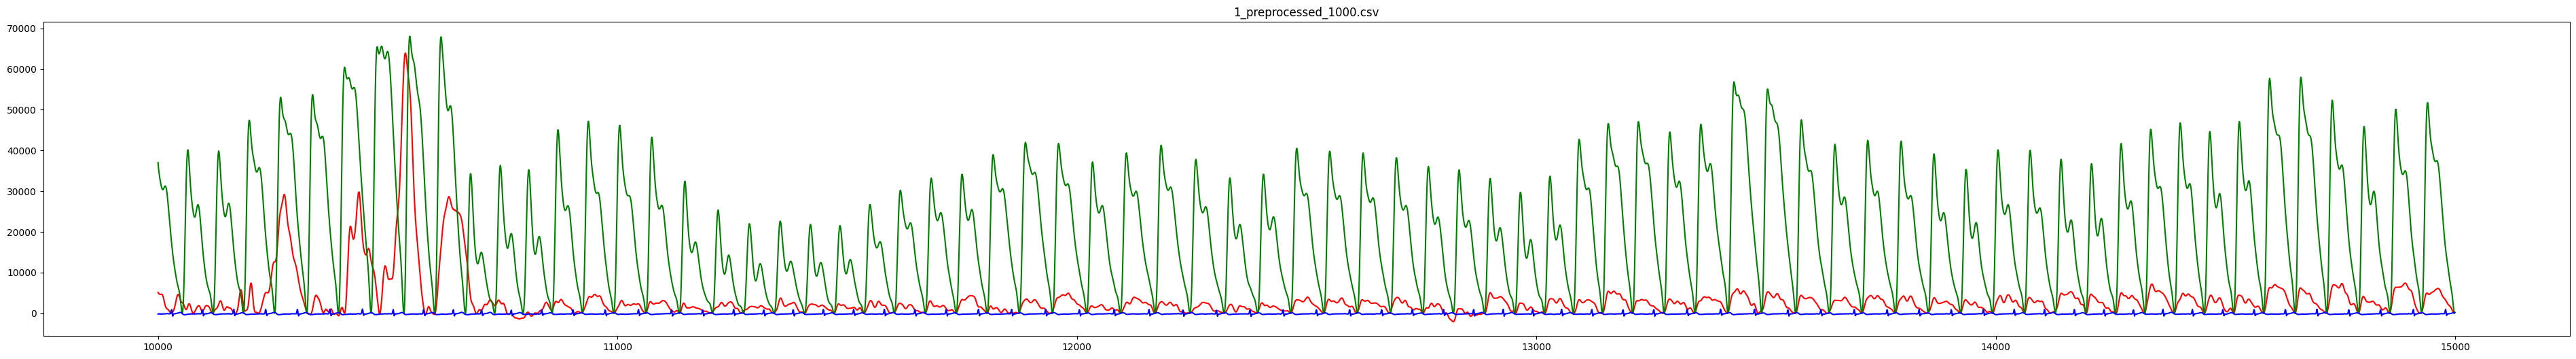

Sys BP 138 Dia BP 84


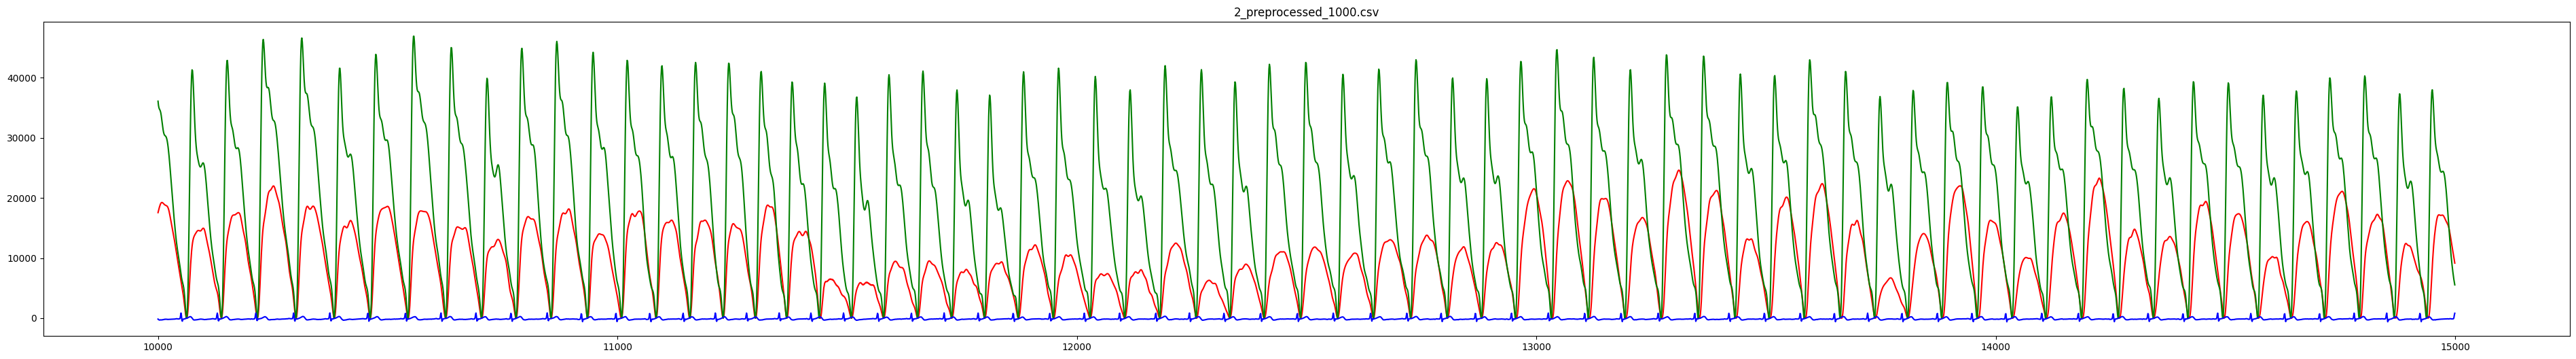

Sys BP 132 Dia BP 93


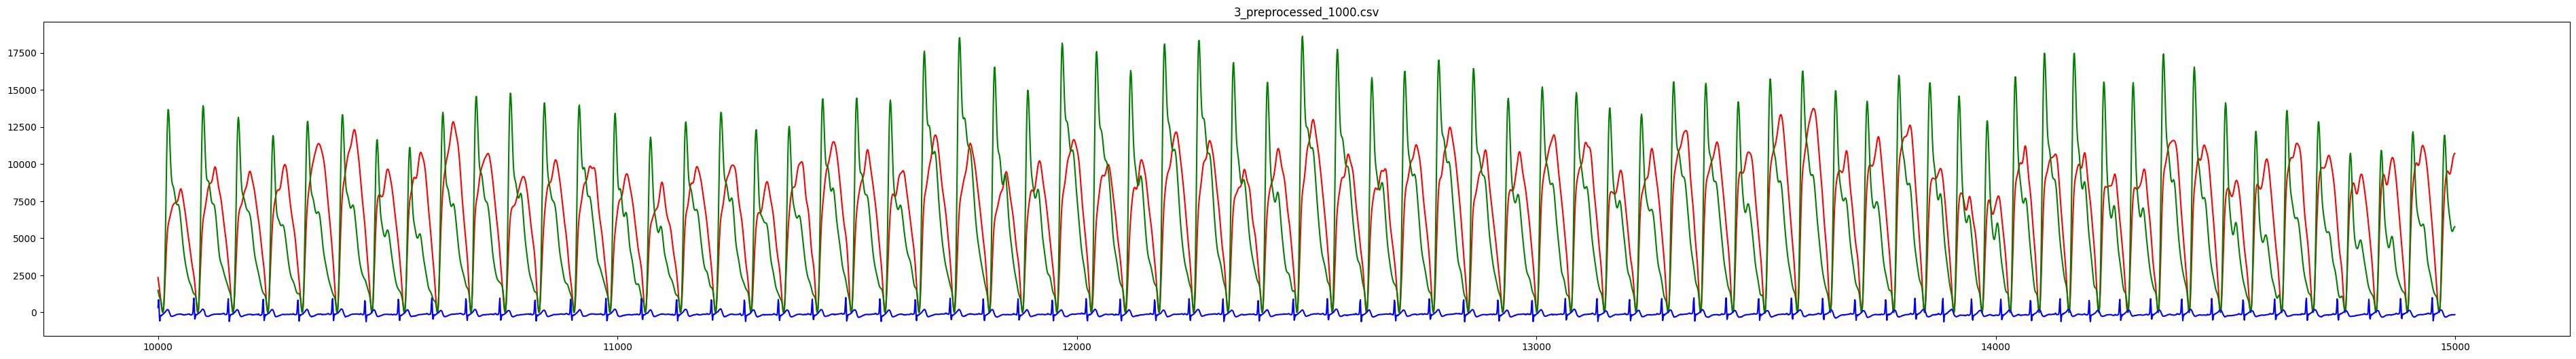

Sys BP 137 Dia BP 88


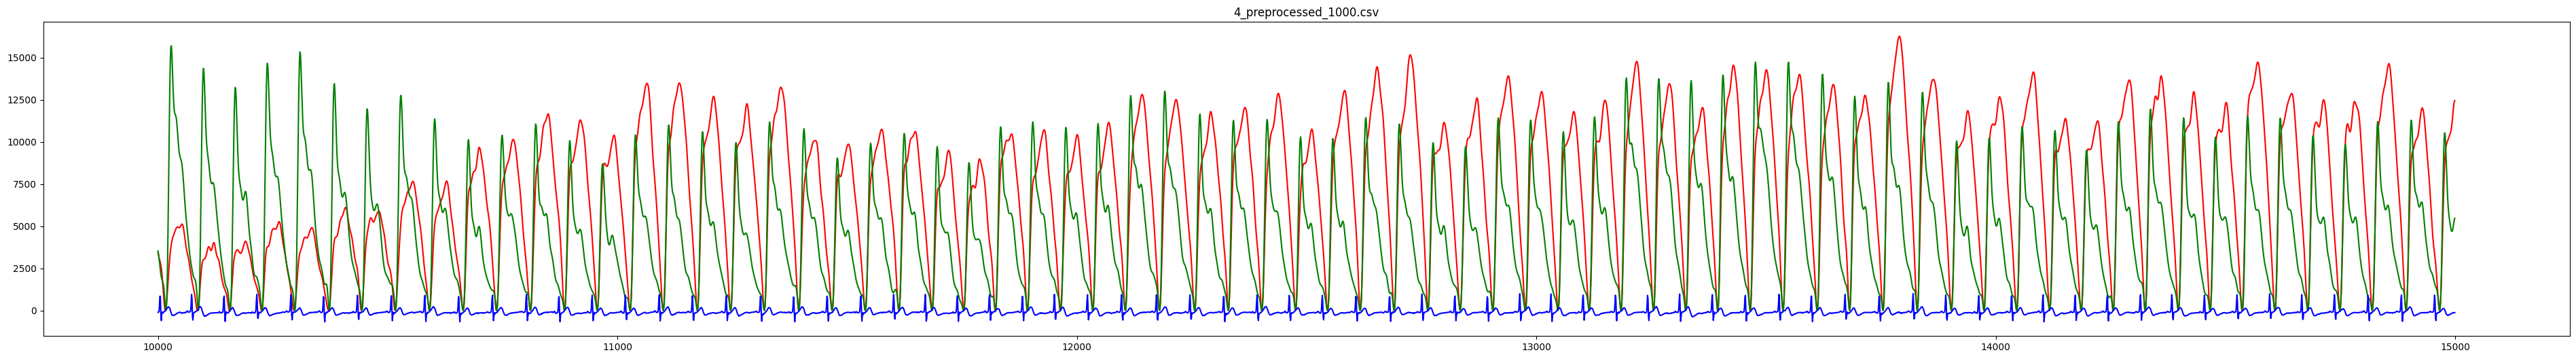

Sys BP 133 Dia BP 95


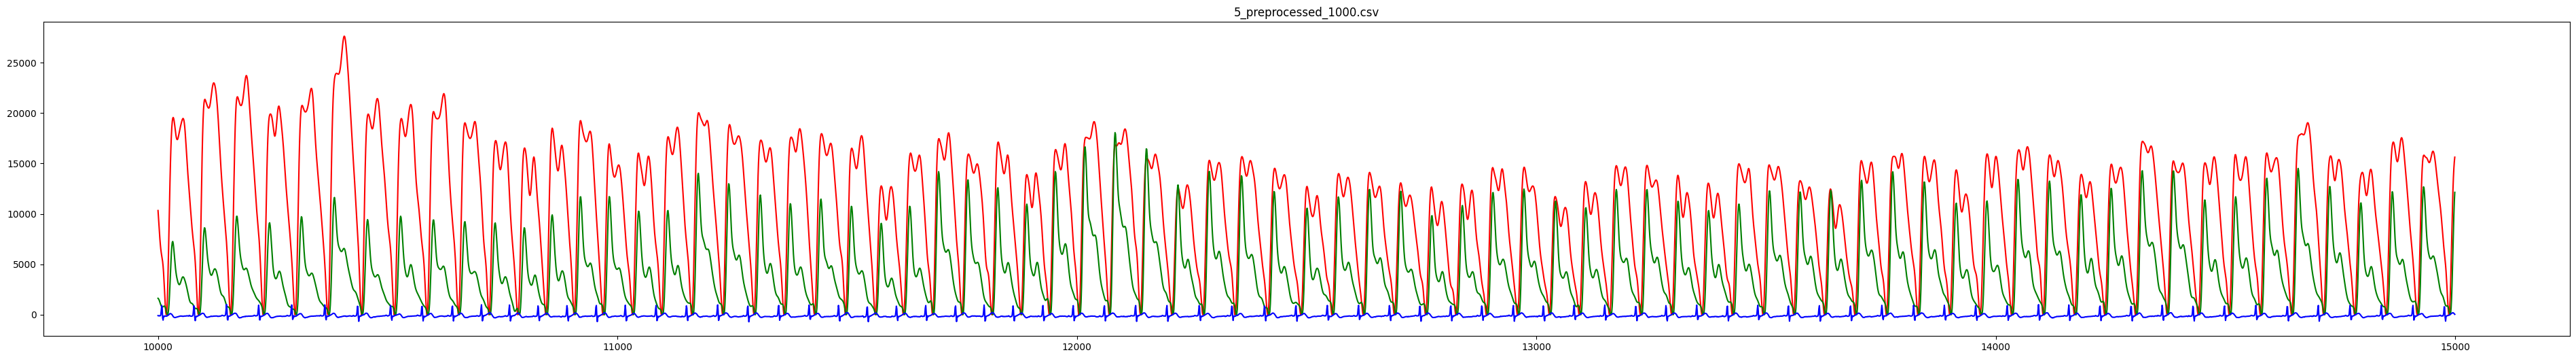

In [18]:
csv_files = [file for file in os.listdir("processed/") if 'preprocessed' in file and file.endswith('.csv')]
csv_files.sort()

i=0

for csv_file in csv_files:
    df = pd.read_csv("processed/" + csv_file)[10000:15000]

    plt.figure(figsize=(48,6))
    plt.plot(df['PPG_In_G_AC']*25, color='r')
    plt.plot(df['PPG_Ref_G_AC']*10, color='g')
    plt.plot(df['ECG']*1000, color='blue')
    plt.title(csv_file)

    print('Sys BP', df['BP_Sys'].values[0], 'Dia BP', df['BP_Dia'].values[0])

    plt.show()